<a href="https://colab.research.google.com/github/pszachew/Delivery-Prediction/blob/master/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [22]:
def get_preprocess():
  deliveries = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/deliveries.jsonl', lines=True)
  sessions = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/sessions.jsonl', lines=True)
  products = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/products.jsonl', lines=True)
  users = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/users.jsonl', lines=True)
  ls=['monday', 'tuesday','wednesday', 'thursday', 'friday', 'saturday', 'sunday']
  deliveries['delivery_timestamp'] = deliveries['delivery_timestamp'].apply(lambda x: pd.to_datetime(x))
  deliveries['delivery_weekday'] = deliveries['delivery_timestamp'].apply(lambda x: ls[x.weekday()])
  deliveries['delivery_day'] = deliveries['delivery_timestamp'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
  deliveries['purchase_timestamp'] = deliveries['purchase_timestamp'].apply(lambda x: pd.to_datetime(x))
  deliveries['purchase_day'] = deliveries['purchase_timestamp'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
  deliveries['diff_days'] = (deliveries['delivery_day'] - deliveries['purchase_day']).apply(lambda x: x.days)
  tmp = deliveries['diff_days']
  deliveries['purchase_morning'] = deliveries['purchase_timestamp'].apply(lambda x: 1 if x.hour<=14 else 0)
  all_info = deliveries.merge(sessions.merge(products, on='product_id', how='left'), on='purchase_id', how='left')
  all_info = all_info.merge(users, on='user_id', how='left')
  dec_var = ["delivery_company", 'diff_days', 'purchase_morning', 'city', 'delivery_weekday']
  all_info = all_info.drop(all_info.index[all_info['diff_days'].isin([0,5])], axis=0)
  all_info = all_info[dec_var]
  city_dum = pd.get_dummies(all_info['city'], drop_first=True)
  weekday_dum = pd.get_dummies(all_info['delivery_weekday'], drop_first=True)
  delivery_company_dum = pd.get_dummies(all_info['delivery_company'], drop_first=True)
  delivery_company_dum = delivery_company_dum.rename(columns={360:'delivery_360', 254:'delivery_254', 516:'delivery_516', 620:'delivery_620'})
  all_info.drop('delivery_company', axis=1, inplace=True)
  all_info.drop('city', axis=1, inplace=True)
  all_info.drop('delivery_weekday', axis=1, inplace=True)
  final = pd.concat([all_info, city_dum, delivery_company_dum, weekday_dum], axis=1)
  return final.drop('diff_days', axis=1), final['diff_days'], tmp

In [23]:
X, y, tmp = get_preprocess()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


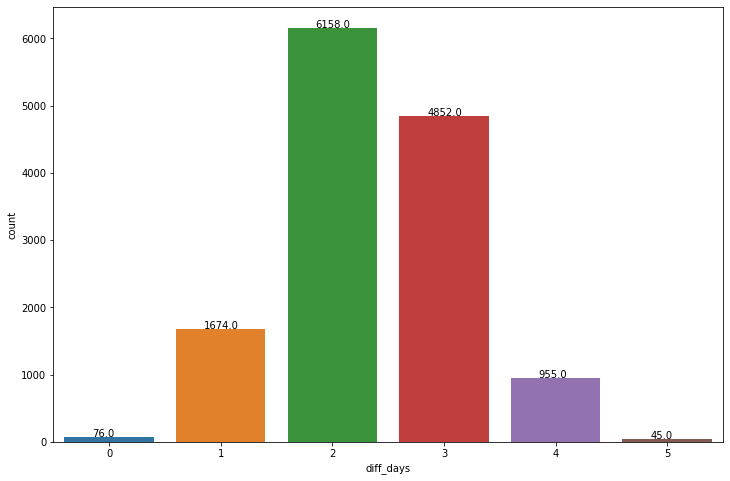

In [26]:
plt.figure(figsize=(12,8))
ax = sns.countplot(tmp)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


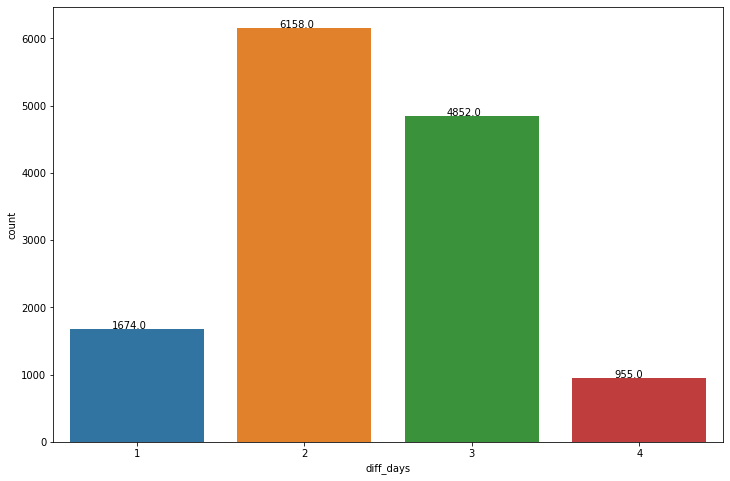

In [27]:
plt.figure(figsize=(12,8))
ax = sns.countplot(y)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

In [4]:
X

,purchase_morning,Kraków,Poznań,Radom,Szczecin,Warszawa,Wrocław,delivery_360,delivery_516,delivery_620,monday,saturday,thursday,tuesday,wednesday
0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
3,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13755,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0
13756,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
13757,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
13758,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [5]:
oversample = SMOTE(k_neighbors=10, sampling_strategy='all')

In [6]:
over_X, over_y = oversample.fit_resample(X,y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


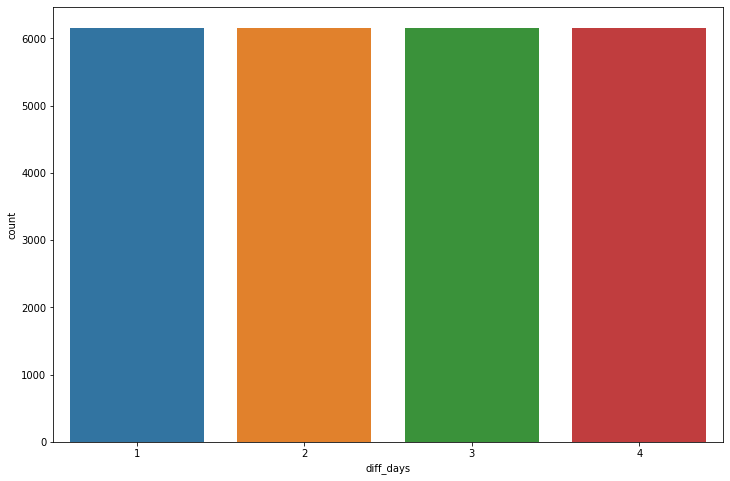

In [17]:
plt.figure(figsize=(12,8))
sns.countplot(over_y)
plt.show()

## **Logistic Regression**

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pre = model.predict(X_test)
print(accuracy_score(y_test, y_pre))
print(classification_report(y_test, y_pre))

0.7018440346589647
              precision    recall  f1-score   support

           1       0.69      0.55      0.61       556
           2       0.66      0.71      0.68      2028
           3       0.75      0.74      0.75      1917

    accuracy                           0.70      4501
   macro avg       0.70      0.67      0.68      4501
weighted avg       0.70      0.70      0.70      4501



In [ ]:
cm = confusion_matrix(y_test, y_pre)

In [ ]:
print(cm)

[[ 305  244    7    0]
 [ 129 1433  456   10]
 [   5  479 1082   45]
 [   0   12  252   42]]


## **SVM**

In [ ]:
from sklearn.svm import SVC

In [ ]:
kernel = 'poly'

In [ ]:
mod_svm = SVC(kernel=kernel)
mod_svm.fit(X_train, y_train)
accuracy_score(y_test, mod_svm.predict(X_test))

0.7191735169962231

In [ ]:
print(classification_report(y_test, mod_svm.predict(X_test)))

              precision    recall  f1-score   support

           1       0.71      0.56      0.63       556
           2       0.69      0.71      0.70      2028
           3       0.75      0.77      0.76      1917

    accuracy                           0.72      4501
   macro avg       0.72      0.68      0.70      4501
weighted avg       0.72      0.72      0.72      4501



## **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors = 5)

In [ ]:
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
print(classification_report(y_test, neigh.predict(X_test)))

              precision    recall  f1-score   support

           1       0.61      0.53      0.56       556
           2       0.63      0.68      0.65      2028
           3       0.60      0.58      0.59      1611
           4       0.41      0.34      0.37       306

    accuracy                           0.60      4501
   macro avg       0.56      0.53      0.55      4501
weighted avg       0.60      0.60      0.60      4501



## **MLPClassifier**

In [8]:
from sklearn.neural_network import MLPClassifier

In [9]:
X_train, X_test, y_train, y_test = train_test_split(over_X, over_y, test_size=0.33, random_state=1)

In [18]:
MLPclass = MLPClassifier(hidden_layer_sizes=(16,16), random_state=8, activation='relu')
MLPclass.fit(X_train, y_train)
y_pred = MLPclass.predict(X_test)

In [19]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.79      0.83      0.81      2027
           2       0.67      0.50      0.57      2124
           3       0.58      0.59      0.58      2000
           4       0.73      0.88      0.80      1978

    accuracy                           0.70      8129
   macro avg       0.69      0.70      0.69      8129
weighted avg       0.69      0.70      0.69      8129



In [20]:
confusion_matrix(y_test, y_pred)

array([[1687,  252,   84,    4],
       [ 387, 1066,  535,  136],
       [  50,  272, 1171,  507],
       [   3,    7,  230, 1738]])